In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

%matplotlib inline

In [3]:
df = pd.read_csv('/Users/Bryan/Documents/Programming/Python_Courses/Tensorflow2/DATA/RSCCASN.csv',
                 parse_dates=True, index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
RSCCASN    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns = ['Sales']

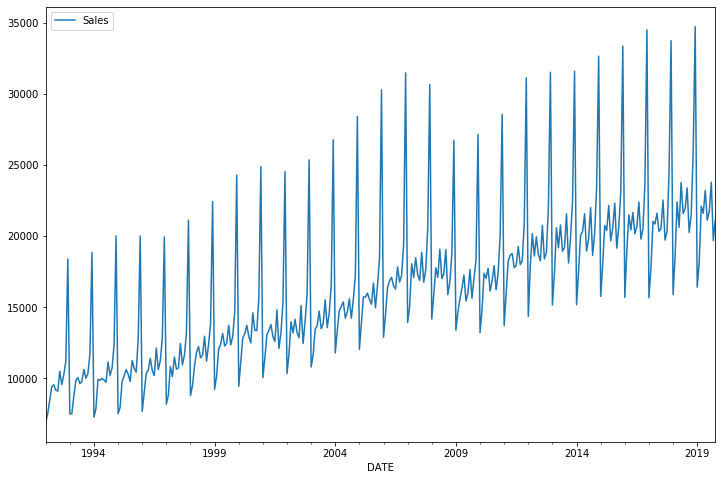

In [6]:
df.plot(figsize=(12,8))

In [7]:
len(df)

334

In [9]:
# pick a cycle and a half 1.5 years

test_size = 18
test_ind = len(df) - test_size
test_ind

316

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [12]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [13]:
# scale the data

from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [20]:
scaled_train = scaler.transform(train)

In [21]:
scaled_test = scaler.transform(test)

In [22]:
# create the timeseries generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
# set batch size shorter than len(test)
# scaled_train is both the source of the X and y

length = 12

generator = TimeseriesGenerator(scaled_train,
                                scaled_train,
                                length=length,
                                batch_size=1)

In [24]:
# look at the first one
X,y = generator[0]

In [25]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [26]:
y

array([[0.02047633]])

In [28]:
len(X[0])

12

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [31]:
import plaidml.keras
plaidml.keras.install_backend()
from keras import backend as K

In [32]:
n_features = 1

In [62]:
# create the model
# input shape is 12 x 1 (length of batch x n_features)
# tried dropout = 0.2, not much better

model = Sequential()
model.add(LSTM(100,activation='relu', input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [63]:
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
# set up early stopping

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [65]:
# make the validation generator using the scaled test data for comparison

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [66]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
322/322 [==============================] - 14s 44ms/step - loss: 0.0242 - val_loss: 0.0299
Epoch 2/20
322/322 [==============================] - 14s 44ms/step - loss: 0.0140 - val_loss: 0.0240
Epoch 3/20
322/322 [==============================] - 14s 44ms/step - loss: 0.0078 - val_loss: 5.8195e-04
Epoch 4/20
322/322 [==============================] - 14s 45ms/step - loss: 0.0041 - val_loss: 9.5150e-04
Epoch 5/20
322/322 [==============================] - 14s 44ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 6/20
322/322 [==============================] - 14s 45ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 7/20
322/322 [==============================] - 15s 45ms/step - loss: 0.0014 - val_loss: 3.8740e-04
Epoch 8/20
322/322 [==============================] - 15s 45ms/step - loss: 0.0012 - val_loss: 2.4120e-04
Epoch 9/20
322/322 [==============================] - 14s 45ms/step - loss: 0.0014 - val_loss: 4.5975e-04
Epoch 10/20
322/322 [==============================] - 14s 44m

In [67]:
losses = pd.DataFrame(model.history.history)

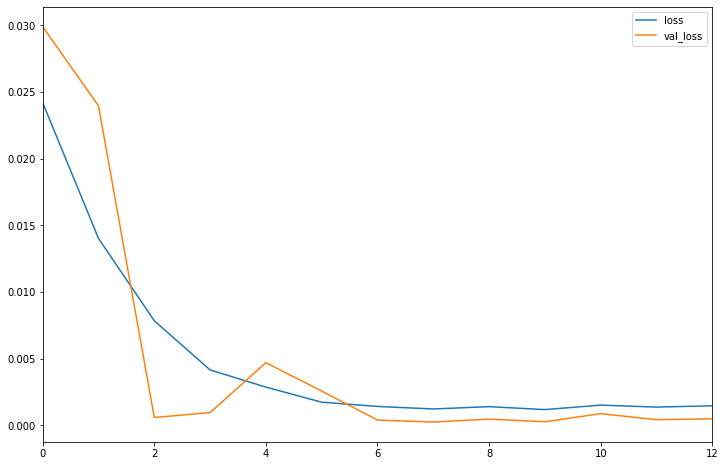

In [68]:
losses.plot(figsize = (12,8))

## Evaluate on Test Data

In [69]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [70]:
true_predictions = scaler.inverse_transform(test_predictions)

In [71]:
test['Predictions'] = true_predictions

/Users/Bryan/anaconda/envs/tf2gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21856.386649
2018-06-01,21589,20665.136709
2018-07-01,21919,20867.333860
2018-08-01,23381,22673.666383
2018-09-01,20260,20038.678437
2018-10-01,21473,20577.824322
2018-11-01,25831,24576.727553
2018-12-01,34706,34147.055022
2019-01-01,16410,16185.666067


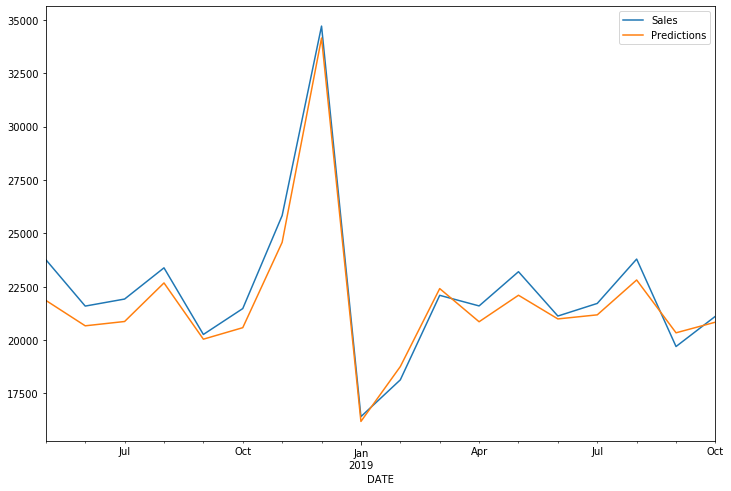

In [73]:
test.plot(figsize=(12,8))

# Retrain and Forecasting OOS

In [74]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [75]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [76]:
# add in dropout to this model

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [77]:
# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 14s 44ms/step - loss: 0.0260
Epoch 2/8
322/322 [==============================] - 14s 44ms/step - loss: 0.0154
Epoch 3/8
322/322 [==============================] - 14s 44ms/step - loss: 0.0082
Epoch 4/8
322/322 [==============================] - 14s 44ms/step - loss: 0.0043
Epoch 5/8
322/322 [==============================] - 14s 44ms/step - loss: 0.0025
Epoch 6/8
322/322 [==============================] - 14s 44ms/step - loss: 0.0021
Epoch 7/8
322/322 [==============================] - 14s 45ms/step - loss: 0.0013
Epoch 8/8
322/322 [==============================] - 14s 45ms/step - loss: 0.0017


In [78]:
forecast = []

# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [79]:
forecast = scaler.inverse_transform(forecast)

In [80]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [81]:
forecast

array([[26172.63365221],
       [36321.80124569],
       [18003.62710762],
       [19544.09950686],
       [22701.83389378],
       [22360.15938091],
       [23796.94867945],
       [22115.65021992],
       [22627.53976583],
       [24435.31210423],
       [21220.8289752 ],
       [22327.17333317]])

### Creating new timestamp index with pandas.

In [82]:
# frequency set to MS = monthly start, first of the month

forecast_index = pd.date_range(start='2019-11-01', periods = periods,
                              freq='MS')

In [83]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [84]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

forecast_df.head()

,Forecast
2019-11-01,26172.633652
2019-12-01,36321.801246
2020-01-01,18003.627108
2020-02-01,19544.099507
2020-03-01,22701.833894


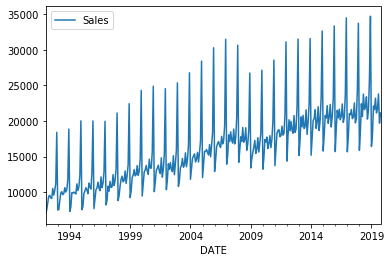

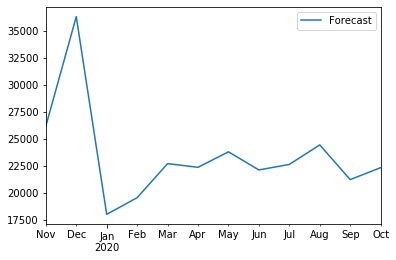

In [85]:
df.plot()
forecast_df.plot()

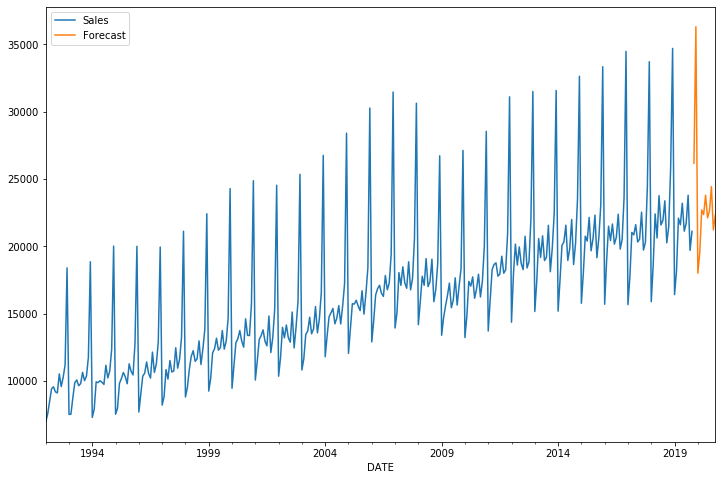

In [87]:
# set the axis
# then add to it

ax = df.plot(figsize = (12,8))
forecast_df.plot(ax=ax)

(528, 611)

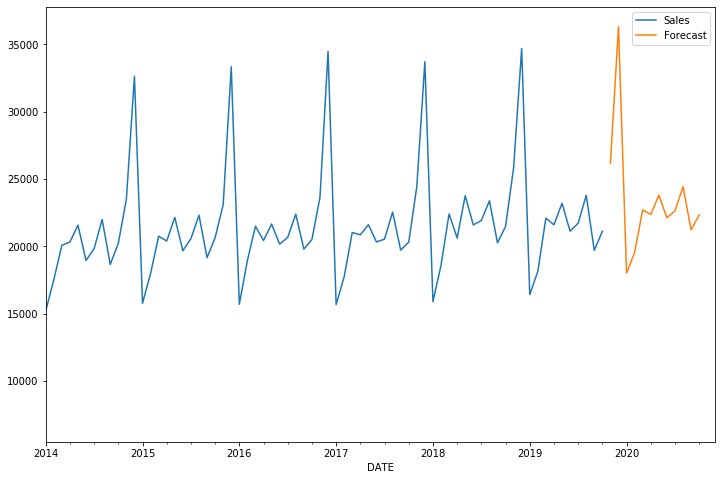

In [89]:
# zoom in with xlim

ax = df.plot(figsize = (12,8))
forecast_df.plot(ax=ax)
plt.xlim('2014-01-01', '2020-12-01')